<a href="https://colab.research.google.com/github/AmanullaChishty/Pytorch/blob/main/PyTorch_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Setup


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
!pip install -q torchinfo

In [3]:
from torchinfo import summary

In [4]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4183, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 4183 (delta 63), reused 110 (delta 42), pack-reused 4035 (from 1)
Receiving objects: 100% (4183/4183), 652.89 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (2435/2435), done.
Updating files: 100% (248/248), done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

In [6]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                    destination="pizza_steak_sushi")
data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. Creating an EffNetB2 feature extractor

In [8]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 131MB/s]


In [9]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [10]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3)
)

In [11]:
def create_effnetb2_model(num_classes:int=3,seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [12]:
effnetb2_model, effnetb2_transforms = create_effnetb2_model(num_classes=3,seed=42)

In [13]:
summary(effnetb2_model, input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [14]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [25]:
# Training EffnetB2 feature extractor

from going_modular.going_modular import engine

optimizer = optim.Adam(params=effnetb2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5208 | train_acc: 0.9297 | test_loss: 0.5735 | test_acc: 0.8873
Epoch: 2 | train_loss: 0.4371 | train_acc: 0.9531 | test_loss: 0.5647 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.4092 | train_acc: 0.9297 | test_loss: 0.5483 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.4437 | train_acc: 0.8320 | test_loss: 0.4792 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.4550 | train_acc: 0.8281 | test_loss: 0.5066 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.3847 | train_acc: 0.9648 | test_loss: 0.4618 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3631 | train_acc: 0.9609 | test_loss: 0.4591 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.4431 | train_acc: 0.8281 | test_loss: 0.4758 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.4280 | train_acc: 0.8242 | test_loss: 0.4571 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.3905 | train_acc: 0.8398 | test_loss: 0.3974 | test_acc: 0.9176


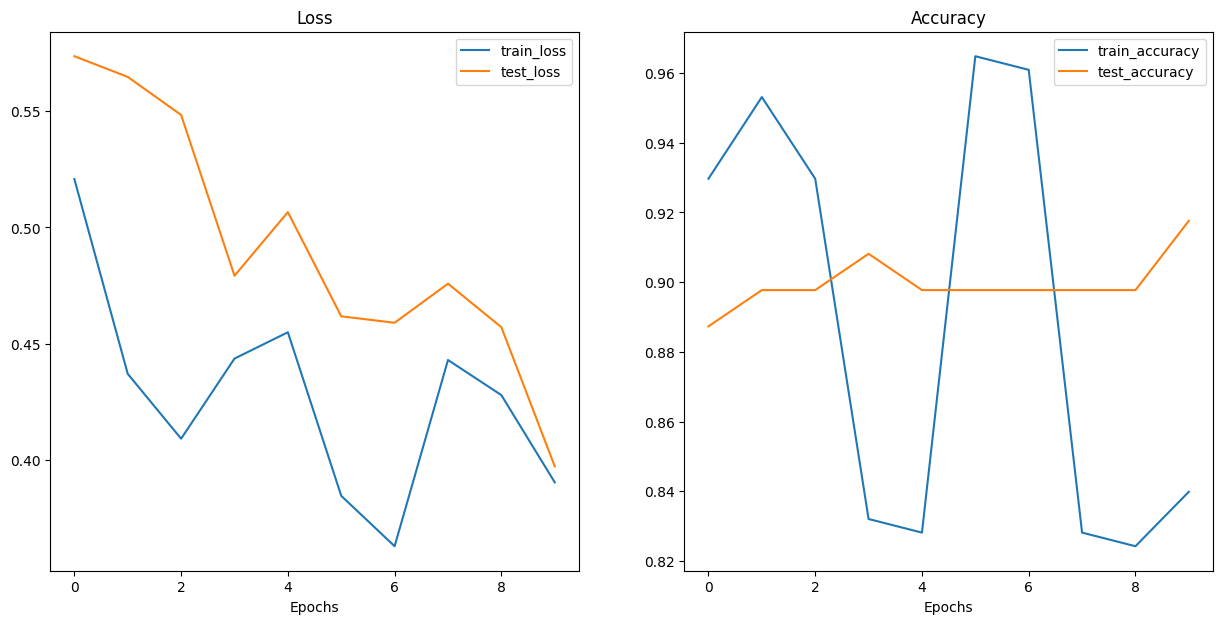

In [26]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

In [27]:
# Saving EffNetB2 feature extractor

from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_effnetb2_feature_extractor.pth")

[INFO] Saving model to: models/09_effnetb2_feature_extractor.pth


In [28]:
# Checking the size of model

from pathlib import Path

model_path = Path("models/09_effnetb2_feature_extractor.pth")
pretrained_effnetb2_model_size=model_path.stat().st_size//(1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [29]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [30]:
# Dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.39738528927167255,
 'test_acc': 0.9176136363636364,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 3. Creating a ViT feature extractor

In [20]:
vit = torchvision.models.vit_b_16()
vit.heads()

In [21]:
def create_vit_model(num_classes:int=3,seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [22]:
vit,vit_transforms = create_vit_model(num_classes=3,seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 138MB/s]


In [23]:
summary(
    vit,
    input_size=(32,3,224,224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [24]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

In [31]:
#Training ViTfeature extractor

from going_modular.going_modular import engine

optimizer = optim.Adam(params=vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7768 | train_acc: 0.6992 | test_loss: 0.5612 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3794 | train_acc: 0.9180 | test_loss: 0.3352 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2297 | train_acc: 0.9414 | test_loss: 0.2830 | test_acc: 0.9290
Epoch: 4 | train_loss: 0.1641 | train_acc: 0.9570 | test_loss: 0.2517 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1322 | train_acc: 0.9766 | test_loss: 0.2329 | test_acc: 0.9186
Epoch: 6 | train_loss: 0.1399 | train_acc: 0.9688 | test_loss: 0.2184 | test_acc: 0.9186
Epoch: 7 | train_loss: 0.1155 | train_acc: 0.9648 | test_loss: 0.2389 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0875 | train_acc: 0.9844 | test_loss: 0.2253 | test_acc: 0.8883
Epoch: 9 | train_loss: 0.1564 | train_acc: 0.9766 | test_loss: 0.2013 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0815 | train_acc: 0.9805 | test_loss: 0.1756 | test_acc: 0.9176


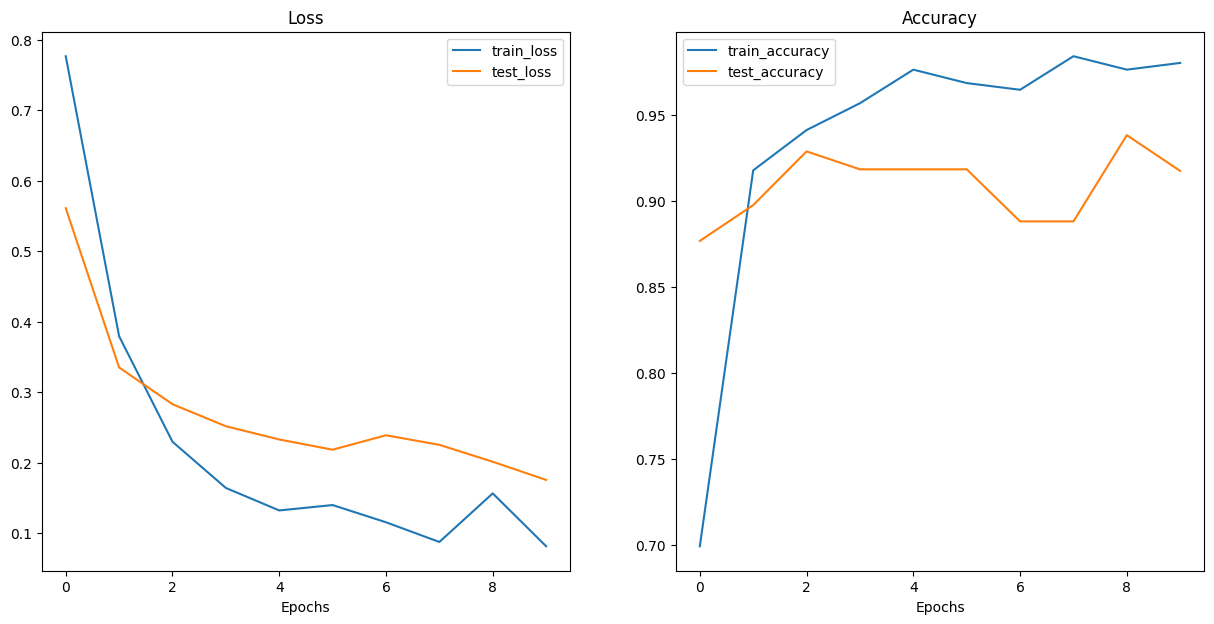

In [32]:
plot_loss_curves(vit_results)

In [33]:
#Save the model

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_vit_feature_extractor.pth")

[INFO] Saving model to: models/09_vit_feature_extractor.pth


In [35]:
model_path = Path("models/09_vit_feature_extractor.pth")
pretrained_vit_model_size=model_path.stat().st_size//(1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [36]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [37]:
# ViT Statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.17558992405732474,
 'test_acc': 0.9176136363636364,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}